Импорты и конфигурация

In [202]:
import os
import re
import pandas as pd
from collections import defaultdict
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from tqdm import tqdm

DATA_DIR = 'data/'

Очистка текста и фрагментация

In [203]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^а-яa-z. ]+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def split_into_chunks(text, max_chunk_len=300):
    sentences = re.split(r'\.\s+', text)
    chunks = []
    chunk = ""

    for sent in sentences:
        if len(chunk) + len(sent) <= max_chunk_len:
            chunk += sent + '. '
        else:
            if len(chunk.strip()) > 50:
                chunks.append(chunk.strip())
            chunk = sent + '. '

    if len(chunk.strip()) > 50:
        chunks.append(chunk.strip())

    return chunks


Сбор и балансировка данных

In [204]:
def read_all_authors_balanced(data_dir, max_samples_per_author=500):
    data = defaultdict(list)

    for fname in os.listdir(data_dir):
        if fname.endswith(".txt") and not fname.startswith("author"):
            author = fname.replace(".txt", "")
            fpath = os.path.join(data_dir, fname)
            with open(fpath, 'r', encoding='utf-8') as f:
                raw = f.read()

            cleaned = clean_text(raw)
            chunks = split_into_chunks(cleaned, max_chunk_len=300)
            chunks = chunks[:max_samples_per_author]

            data['text'].extend(chunks)
            data['author'].extend([author] * len(chunks))

    df = pd.DataFrame(data)
    df = shuffle(df, random_state=42).reset_index(drop=True)
    return df


Построение словаря и кодирование текста

In [205]:
def build_vocab(texts, min_freq=1):
    word_freq = defaultdict(int)
    for text in texts:
        for word in text.split():
            word_freq[word] += 1

    vocab = {word: idx + 2 for idx, (word, freq) in enumerate(word_freq.items()) if freq >= min_freq}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

def encode_text(text, vocab, max_len):
    encoded = [vocab.get(word, vocab['<UNK>']) for word in text.split()]
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded


Кастомный Dataset и сборка финальной выборки

In [206]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = encode_text(self.texts[idx], self.vocab, self.max_len)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

def prepare_dataset(df, max_len=200):
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['author'])
    vocab = build_vocab(df['text'])
    dataset = TextDataset(df['text'].tolist(), df['label'].tolist(), vocab, max_len)
    return dataset, vocab, le


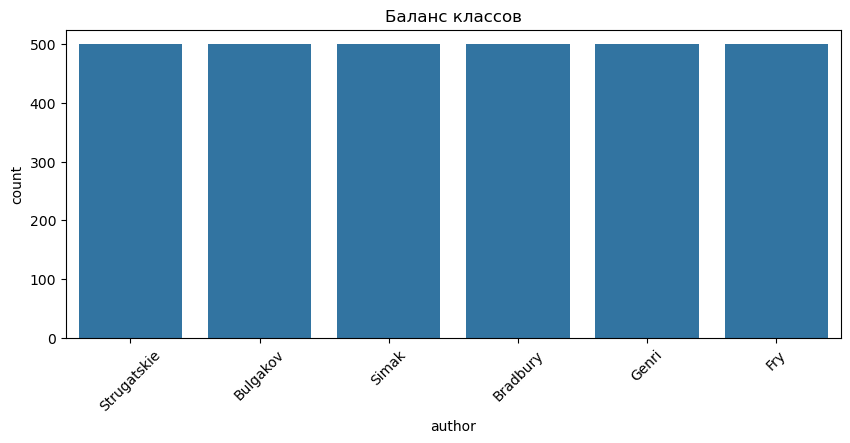

Пример текста: а я тебя ни о чем не спрашиваю пока.драмба промолчал.они шагали через степь все больше уклоняясь от прямой дороги к дому потому что гагу стало вдруг интересно посмотреть что за сооружение торчит на небольшом холме справа.
Токенизированный: tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 24, 30, 31, 32, 33, 34, 35, 36,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
Метка (label): tensor(5)


In [207]:
df = read_all_authors_balanced(DATA_DIR, max_samples_per_author=500)
df.head()

plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='author', order=df['author'].value_counts().index)
plt.title("Баланс классов")
plt.xticks(rotation=45)
plt.show()

dataset, vocab, label_encoder = prepare_dataset(df, max_len=100)

# Проверка одного примера
print("Пример текста:", df.iloc[0]['text'])
print("Токенизированный:", dataset[0][0])
print("Метка (label):", dataset[0][1])


Разделение на train / validation и DataLoader

In [208]:
# Загружаем и подготавливаем
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['author'], random_state=42)

# Строим датасеты
train_dataset, vocab, label_encoder = prepare_dataset(train_df, max_len=100)
val_dataset = TextDataset(val_df['text'].tolist(), 
                          label_encoder.transform(val_df['author']), 
                          vocab, max_len=100)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Модель на LSTM (PyTorch)

In [209]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):  # <== ОБЯЗАТЕЛЬНО внутри класса, с отступом
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)

        # объединяем два направления
        hidden = torch.cat((hidden[0], hidden[1]), dim=1)
        out = self.dropout(hidden)
        return self.fc(out)


In [210]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

embedding_dim = 200
hidden_dim = 128
output_dim = len(label_encoder.classes_)
padding_idx = vocab['<PAD>']

model = LSTMClassifier(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    padding_idx=padding_idx,
    dropout=0.3
).to(device)

print(model)


Using device: cuda
LSTMClassifier(
  (embedding): Embedding(27360, 200, padding_idx=0)
  (lstm): LSTM(200, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)


Обучение модели + валидация

In [211]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []
        true_labels = []
        pred_labels = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
            x_batch, y_batch = [b.to(device) for b in batch]

            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            true_labels.extend(y_batch.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

        train_acc = accuracy_score(true_labels, pred_labels)
        avg_loss = sum(train_losses) / len(train_losses)
        val_acc = evaluate_model(model, val_loader)

        history['train_loss'].append(avg_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch} — Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Визуализация
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title('Train Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return history

In [212]:
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    return accuracy_score(all_labels, all_preds)


Epoch 1: 100%|██████████| 38/38 [00:00<00:00, 94.78it/s] 


Epoch 1 — Train Loss: 1.7836, Train Acc: 0.2021, Val Acc: 0.2283


Epoch 2: 100%|██████████| 38/38 [00:00<00:00, 171.16it/s]


Epoch 2 — Train Loss: 1.6949, Train Acc: 0.3829, Val Acc: 0.2450


Epoch 3: 100%|██████████| 38/38 [00:00<00:00, 176.78it/s]


Epoch 3 — Train Loss: 1.4815, Train Acc: 0.4608, Val Acc: 0.2617


Epoch 4: 100%|██████████| 38/38 [00:00<00:00, 190.04it/s]


Epoch 4 — Train Loss: 1.1547, Train Acc: 0.6067, Val Acc: 0.3017


Epoch 5: 100%|██████████| 38/38 [00:00<00:00, 177.00it/s]


Epoch 5 — Train Loss: 0.7745, Train Acc: 0.7488, Val Acc: 0.3133


Epoch 6: 100%|██████████| 38/38 [00:00<00:00, 167.10it/s]


Epoch 6 — Train Loss: 0.4686, Train Acc: 0.8646, Val Acc: 0.3583


Epoch 7: 100%|██████████| 38/38 [00:00<00:00, 172.62it/s]


Epoch 7 — Train Loss: 0.2519, Train Acc: 0.9437, Val Acc: 0.3483


Epoch 8: 100%|██████████| 38/38 [00:00<00:00, 182.07it/s]


Epoch 8 — Train Loss: 0.1373, Train Acc: 0.9704, Val Acc: 0.3367


Epoch 9: 100%|██████████| 38/38 [00:00<00:00, 177.56it/s]


Epoch 9 — Train Loss: 0.0848, Train Acc: 0.9854, Val Acc: 0.3533


Epoch 10: 100%|██████████| 38/38 [00:00<00:00, 177.59it/s]


Epoch 10 — Train Loss: 0.0509, Train Acc: 0.9904, Val Acc: 0.3617


Epoch 11: 100%|██████████| 38/38 [00:00<00:00, 173.68it/s]


Epoch 11 — Train Loss: 0.0307, Train Acc: 0.9971, Val Acc: 0.3717


Epoch 12: 100%|██████████| 38/38 [00:00<00:00, 198.20it/s]


Epoch 12 — Train Loss: 0.1664, Train Acc: 0.9575, Val Acc: 0.4100


Epoch 13: 100%|██████████| 38/38 [00:00<00:00, 189.18it/s]


Epoch 13 — Train Loss: 0.0725, Train Acc: 0.9871, Val Acc: 0.3867


Epoch 14: 100%|██████████| 38/38 [00:00<00:00, 185.06it/s]


Epoch 14 — Train Loss: 0.0319, Train Acc: 0.9958, Val Acc: 0.4300


Epoch 15: 100%|██████████| 38/38 [00:00<00:00, 178.23it/s]


Epoch 15 — Train Loss: 0.0141, Train Acc: 0.9996, Val Acc: 0.4067


Epoch 16: 100%|██████████| 38/38 [00:00<00:00, 190.27it/s]


Epoch 16 — Train Loss: 0.0181, Train Acc: 0.9975, Val Acc: 0.3883


Epoch 17: 100%|██████████| 38/38 [00:00<00:00, 174.47it/s]


Epoch 17 — Train Loss: 0.0066, Train Acc: 1.0000, Val Acc: 0.3917


Epoch 18: 100%|██████████| 38/38 [00:00<00:00, 188.08it/s]


Epoch 18 — Train Loss: 0.0047, Train Acc: 1.0000, Val Acc: 0.4050


Epoch 19: 100%|██████████| 38/38 [00:00<00:00, 183.76it/s]


Epoch 19 — Train Loss: 0.0065, Train Acc: 0.9996, Val Acc: 0.3883


Epoch 20: 100%|██████████| 38/38 [00:00<00:00, 187.62it/s]


Epoch 20 — Train Loss: 0.0043, Train Acc: 1.0000, Val Acc: 0.4000


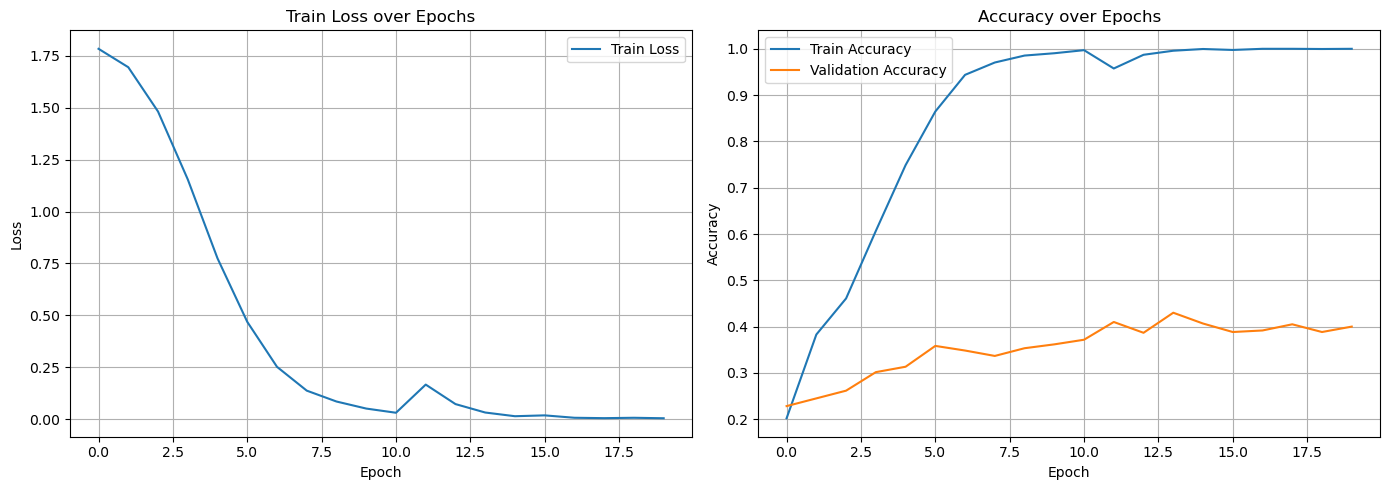

{'train_loss': [1.7836439609527588,
  1.6949202230102138,
  1.4815464584450972,
  1.1547185198256844,
  0.7744549544234025,
  0.4686197309117568,
  0.2518814519832009,
  0.13727144426421115,
  0.08483560226465527,
  0.05091573969510041,
  0.030742293150213203,
  0.16636003605335167,
  0.07250238322701894,
  0.031872834226018505,
  0.014061776100118694,
  0.018125598698756414,
  0.006590207805857062,
  0.004720165363610967,
  0.0065477758425434955,
  0.00426611070227074],
 'train_acc': [0.20208333333333334,
  0.3829166666666667,
  0.4608333333333333,
  0.6066666666666667,
  0.74875,
  0.8645833333333334,
  0.94375,
  0.9704166666666667,
  0.9854166666666667,
  0.9904166666666666,
  0.9970833333333333,
  0.9575,
  0.9870833333333333,
  0.9958333333333333,
  0.9995833333333334,
  0.9975,
  1.0,
  1.0,
  0.9995833333333334,
  1.0],
 'val_acc': [0.22833333333333333,
  0.245,
  0.26166666666666666,
  0.3016666666666667,
  0.31333333333333335,
  0.35833333333333334,
  0.34833333333333333,
  0

In [213]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_loader, val_loader, optimizer, criterion, epochs=20)


Отчёт и матрица

In [214]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    return all_labels, all_preds


Classification Report:

              precision    recall  f1-score   support

    Bradbury       0.89      0.16      0.27       100
    Bulgakov       0.73      0.27      0.39       100
         Fry       0.49      0.71      0.58       100
       Genri       0.70      0.07      0.13       100
       Simak       0.30      0.53      0.38       100
 Strugatskie       0.31      0.66      0.42       100

    accuracy                           0.40       600
   macro avg       0.57      0.40      0.36       600
weighted avg       0.57      0.40      0.36       600



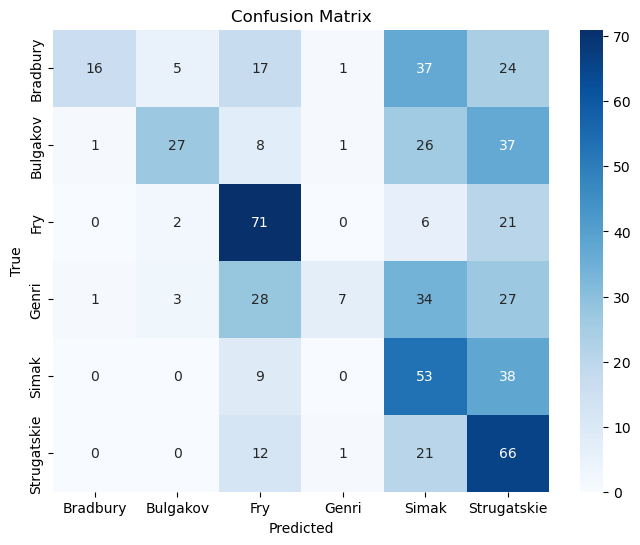

In [215]:
# Получаем метки и предсказания
true_labels, pred_labels = get_predictions(model, val_loader)

# Расшифровка чисел в имена авторов
label_names = label_encoder.classes_

# Classification report
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=label_names))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
